# Problem 2

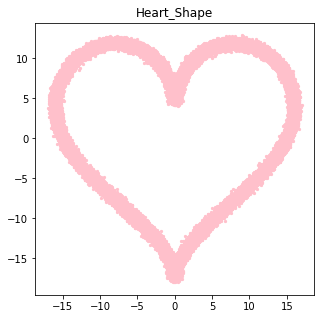

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gtda.mapper import Projection, CubicalCover, make_mapper_pipeline
from gtda.mapper import plot_static_mapper_graph, plot_interactive_mapper_graph
from sklearn.cluster import DBSCAN
from sklearn.base import TransformerMixin

# Function to generate a heart shape
def heart_shape(n_points=1000, noise=0.1):
    t = np.linspace(0, 2 * np.pi, n_points)
    x = 16 * np.sin(t) ** 3
    y = 13 * np.cos(t) - 5 * np.cos(2 * t) - 2 * np.cos(3 * t) - np.cos(4 * t)
    data = np.vstack((x, y)).T
    data += noise * np.random.randn(*data.shape)  # Adding some noise
    return data

# Generate heart shape data
X_heart = heart_shape(n_points=100000, noise=0.3)

# Plot the heart shape with pink color
plt.figure(figsize=(5, 5))
plt.scatter(X_heart[:, 0], X_heart[:, 1], s=5, color='pink')
plt.title("Heart_Shape")
plt.show()

# Mapper parameters
filter_func = Projection(columns=[0])
cover = CubicalCover(n_intervals=15, overlap_frac=0.2)
clusterer = DBSCAN()

# Create and run the mapper pipeline
pipe = make_mapper_pipeline(filter_func=filter_func,
                            cover=cover,
                            clusterer=clusterer,
                            verbose=False)

# Generate and plot Mapper graph
fig = plot_static_mapper_graph(pipe, X_heart)
fig.show()


# Problem 3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
# filter
from sklearn.base import TransformerMixin
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
# mapper
from gtda.mapper import Projection, CubicalCover, make_mapper_pipeline, method_to_transform, plot_static_mapper_graph

In [3]:
# Amount log scaling
df = pd.read_csv('creditcard.csv')
df['Amount'] = df['Amount'].apply(lambda x: np.log1p(x))
# choose data when Time <= 100,000
# df = df[df['Time'] < 100000]
del df['Time'], df['V8'], df['V13'], df['V15'], df['V20'], df['V1'], df['V2'], df['V5'], df['V6'], df['V7'], df['V21'], df['V22'], df['V23'], df['V24'], df['V25'], df['V26'], df['V27'],df['V28']
X = df.drop('Class', axis = 1).values
y = df['Class'].values

In [6]:
class FilterFunction(TransformerMixin):
    def __init__(self, n_neighbors, n_jobs):
        super().__init__()
        self.isolation = IsolationForest(n_jobs = n_jobs)
        self.knn = NearestNeighbors(n_neighbors = n_neighbors+1, n_jobs=n_jobs)

    def fit(self, X, y=None):
        self.isolation.fit(X)
        self.knn.fit(X)
        return self

    def transform(self, X, y = None):
        lens1 = self.isolation.decision_function(X)
        if lens1.ndim == 1:
            lens1 = lens1[:, None]
        lens2 = self.knn.kneighbors(X, self.knn.n_neighbors)[0][:,1:]
        if lens2.ndim == 1:
            lens2 = lens2[:, None]
        lens3 = np.linalg.norm(X, axis = 1)
        if lens3.ndim == 1:
            lens3 = lens3[:, None]
        lens = np.concatenate((lens1, lens2, lens3), axis = 1)
        return lens

In [7]:
 # 1. Filter function
filter_func = FilterFunction(n_neighbors = 1, n_jobs=-1)

# 2. Cover
cover = CubicalCover(n_intervals = 7, overlap_frac = 0.3)
# 3. Clustering
clusterer = DBSCAN(eps=0.3, min_samples=100)
pipe = make_mapper_pipeline(scaler = MinMaxScaler(), filter_func=filter_func, cover=cover, clusterer=clusterer, verbose=True, n_jobs=-1)
plotly_params = {"edge_trace": {"line_width": 0.2}, "node_trace": {"marker_colorscale":'Bluered'}}
fig = plot_static_mapper_graph(pipe, X, layout='fr', color_data=y, node_scale=30, plotly_params=plotly_params)
fig.show(config={'scrollZoom': True})


[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=  59.4s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   5.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total= 1.1min
[Pipeline] ........ (step 2 of 3) Processing clustering, total= 1.0min
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   1.8s
